<a href="https://colab.research.google.com/github/sharjh/AI-monitoring-of-rail-defects/blob/main/AI_based_rail_defect_monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from google.colab import drive

# Mount Google Drive to access the CSV files
drive.mount('/content/drive')

csv_folder_path = '/content/drive/MyDrive/dataset/'
preprocessed_folder_path = '/content/drive/MyDrive/preprocessed/'

column_names = ['timestamp', 'temperature', 'humidity', 'x', 'y', 'z']

window_size = 100

Mounted at /content/drive


# Pre Processing function

In [2]:
from scipy.signal.windows import hamming
import numpy as np

def preprocess_csv(file_path, window_size=100, save_path=None):
    """
    Preprocess a single CSV file of accelerometer data using Hamming window and FFT for frequency domain analysis.

    Parameters:
    - file_path (str): Path to the CSV file.
    - window_size (int): Number of timesteps in each window (set to 100 for better frequency resolution).
    - save_path (str): Path to save the preprocessed data (optional).

    Returns:
    - windows_df (pd.DataFrame): A DataFrame where each row is a flattened magnitude spectrum.
    """
    # Step 1: Load the CSV file
    df = pd.read_csv(file_path, names=column_names, parse_dates=['timestamp'])

    # Step 2: Sort by timestamp (just to be safe)
    df = df.sort_values(by='timestamp').reset_index(drop=True)

    # Step 3: Handle missing values using interpolation for x, y, z
    df[['x', 'y', 'z']] = df[['x', 'y', 'z']].interpolate(method='linear')

    # Drop any remaining NaN values (e.g., at the start)
    df = df.dropna()

    # Step 4: Normalize the accelerometer data (x, y, z)
    scaler = StandardScaler()
    df[['x', 'y', 'z']] = scaler.fit_transform(df[['x', 'y', 'z']])

    # Step 5: Segment the data into windows
    windows = []
    for i in range(0, len(df) - window_size + 1):
        window = df[['x', 'y', 'z']].iloc[i:i + window_size].values  # Shape: (window_size, 3)

        # Step 6: Apply Hamming window
        window_hamming = window * hamming(window_size)[:, np.newaxis]  # Apply to all axes

        # Step 7: Compute FFT for each axis (x, y, z)
        fft_x = np.abs(np.fft.fft(window_hamming[:, 0]))  # Magnitude spectrum for x
        fft_y = np.abs(np.fft.fft(window_hamming[:, 1]))  # Magnitude spectrum for y
        fft_z = np.abs(np.fft.fft(window_hamming[:, 2]))  # Magnitude spectrum for z

        # Take the first half of the FFT (unique frequencies up to Nyquist)
        n_unique = window_size // 2 + 1
        fft_x = fft_x[:n_unique]
        fft_y = fft_y[:n_unique]
        fft_z = fft_z[:n_unique]

        # Flatten the magnitude spectra into a single array per window
        fft_window = np.concatenate([fft_x, fft_y, fft_z])
        windows.append(fft_window)

    # Convert windows to a DataFrame
    windows_df = pd.DataFrame(windows)

    # Step 8: Save the preprocessed data if save_path is provided
    if save_path:
        output_filename = os.path.join(save_path, os.path.basename(file_path).replace('.csv', '_freq_preprocessed.pkl'))
        windows_df.to_pickle(output_filename)
        print(f"Saved frequency-domain preprocessed data to {output_filename}")

    return windows_df


# Test the function with a single file (replace with one of your file paths)
sample_file = csv_folder_path + '102_2021_07_30_09_19_50.csv'
windows_df = preprocess_csv(sample_file, window_size)
print("Shape of preprocessed windows:", windows_df.shape)
print(windows_df.head())

Shape of preprocessed windows: (2320, 153)
        0         1         2         3         4         5         6    \
0  0.534775  1.537780  1.386963  0.943854  1.896811  1.808016  1.220666   
1  0.644780  1.547524  1.385532  0.892063  1.905965  1.785854  1.262756   
2  0.691574  1.570582  1.383792  0.881417  1.890938  1.768328  1.287955   
3  0.695746  1.608971  1.376866  0.877139  1.879000  1.728919  1.329503   
4  0.759570  1.619049  1.387141  0.879988  1.847763  1.722679  1.330925   

        7         8         9    ...       143       144       145       146  \
0  1.721218  1.615523  1.118197  ...  1.876805  3.914076  2.657697  2.016340   
1  1.695576  1.665162  1.061682  ...  1.941755  3.874911  2.680529  2.013690   
2  1.721743  1.655753  1.041659  ...  1.989211  3.849205  2.681223  2.021075   
3  1.750800  1.635035  1.000123  ...  2.035604  3.820989  2.678918  2.020864   
4  1.779613  1.618007  0.991213  ...  2.045143  3.827762  2.644105  2.036359   

        147       148    

In [3]:
import glob
import os

# Get a list of all CSV files in the folder
csv_files = glob.glob(csv_folder_path + '*.csv')

# Ensure the preprocessed folder exists in Google Drive
os.makedirs(preprocessed_folder_path, exist_ok=True)

# Iterate over each CSV file, preprocess with Hamming and FFT, and save to Google Drive
for file_path in csv_files:
    print(f"Preprocessing and saving file: {file_path}")
    # Extract the base filename to create a unique preprocessed filename
    base_filename = os.path.basename(file_path).replace('.csv', '_freq_preprocessed.pkl')
    output_path = os.path.join(preprocessed_folder_path, base_filename)

    # Preprocess the file and save directly to Google Drive
    windows_df = preprocess_csv(file_path, window_size)
    windows_df.to_pickle(output_path)  # Explicitly save to Google Drive
    print(f"Successfully saved frequency-domain preprocessed data to {output_path}")

    # Verify the file was saved to Google Drive
    if os.path.exists(output_path):
        print(f"Confirmed: Preprocessed file exists at {output_path}")
    else:
        print(f"Error: Preprocessed file not found at {output_path}")

Preprocessing and saving file: /content/drive/MyDrive/dataset/7_2021_07_26_10_18_17.csv
Successfully saved frequency-domain preprocessed data to /content/drive/MyDrive/preprocessed/7_2021_07_26_10_18_17_freq_preprocessed.pkl
Confirmed: Preprocessed file exists at /content/drive/MyDrive/preprocessed/7_2021_07_26_10_18_17_freq_preprocessed.pkl
Preprocessing and saving file: /content/drive/MyDrive/dataset/119_2021_07_31_02_20_02.csv
Successfully saved frequency-domain preprocessed data to /content/drive/MyDrive/preprocessed/119_2021_07_31_02_20_02_freq_preprocessed.pkl
Confirmed: Preprocessed file exists at /content/drive/MyDrive/preprocessed/119_2021_07_31_02_20_02_freq_preprocessed.pkl
Preprocessing and saving file: /content/drive/MyDrive/dataset/66_2021_07_28_21_19_16.csv
Successfully saved frequency-domain preprocessed data to /content/drive/MyDrive/preprocessed/66_2021_07_28_21_19_16_freq_preprocessed.pkl
Confirmed: Preprocessed file exists at /content/drive/MyDrive/preprocessed/66_2

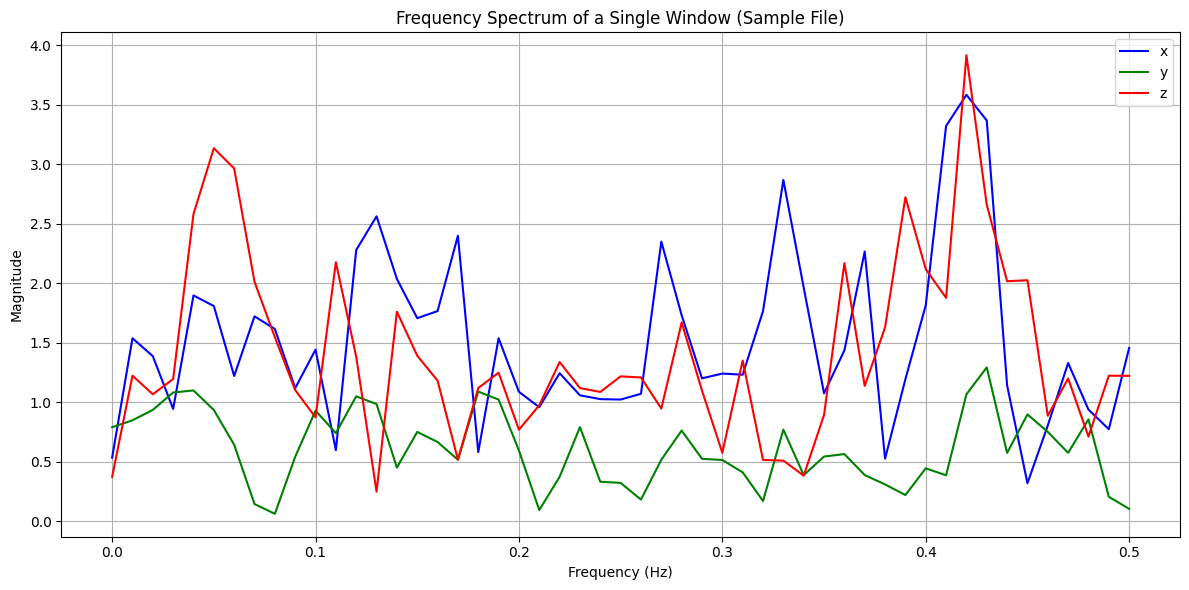

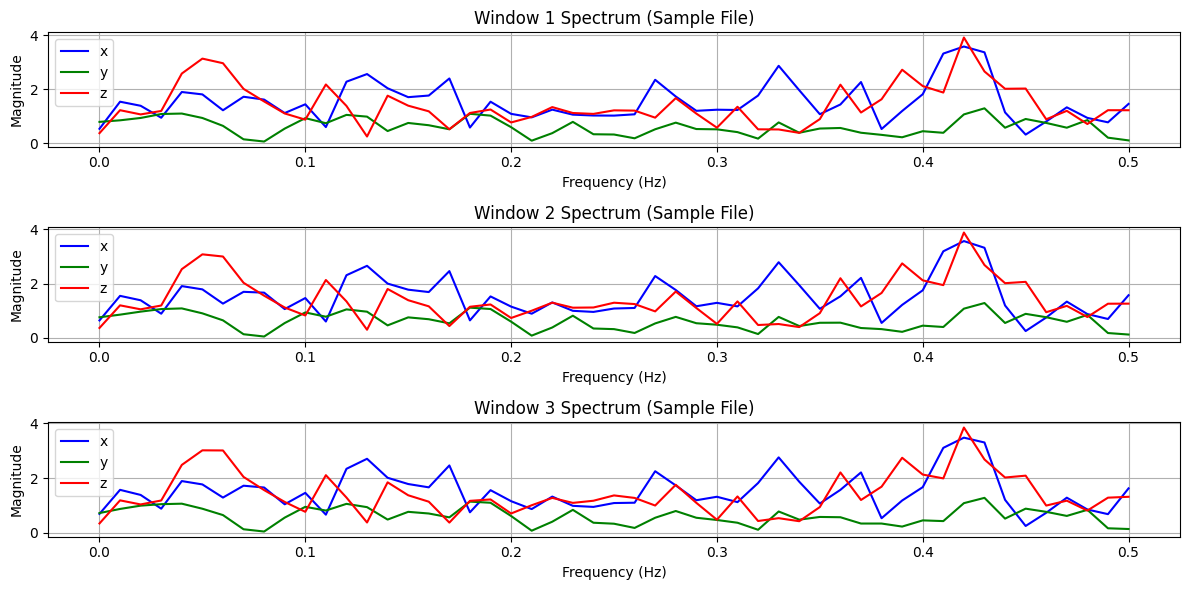

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Use the windows_df variable from the sample file test in Block 2
# Note: This assumes windows_df is still in memory from the previous block's execution
windows_df = windows_df  # Reference to the variable set in Block 2

# Window size and number of unique frequency bins
window_size = 100
n_unique = window_size // 2 + 1  # Number of unique frequencies (50 for window_size=100)

# Step 1: Visualize the frequency spectrum for a single window
# Select the first window
sample_window = windows_df.iloc[0].values  # Shape: (n_unique * 3)
freq_x = sample_window[:n_unique]  # First 50 values for x
freq_y = sample_window[n_unique:2*n_unique]  # Next 50 for y
freq_z = sample_window[2*n_unique:]  # Last 50 for z

# Frequency axis (0 to 0.5 Hz with 0.01 Hz resolution)
freqs = np.linspace(0, 0.5, n_unique)

# Plot the magnitude spectrum
plt.figure(figsize=(12, 6))
plt.plot(freqs, freq_x, label='x', color='blue')
plt.plot(freqs, freq_y, label='y', color='green')
plt.plot(freqs, freq_z, label='z', color='red')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of a Single Window (Sample File)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()  # Display the plot in the notebook

# Step 2: Visualize spectra of multiple windows
num_windows_to_plot = 3
plt.figure(figsize=(12, 6))
for i in range(min(num_windows_to_plot, len(windows_df))):
    window = windows_df.iloc[i].values
    freq_x = window[:n_unique]
    freq_y = window[n_unique:2*n_unique]
    freq_z = window[2*n_unique:]

    plt.subplot(num_windows_to_plot, 1, i+1)
    plt.plot(freqs, freq_x, label='x', color='blue')
    plt.plot(freqs, freq_y, label='y', color='green')
    plt.plot(freqs, freq_z, label='z', color='red')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(f'Window {i+1} Spectrum (Sample File)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()  # Display the multi-window plot in the notebook

# Training

Total number of windows from 66 files: 149543
Training data shape: (119634, 153), Test data shape: (29909, 153)
Epoch 1/100
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.6609 - val_loss: 0.4314
Epoch 2/100
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.4216 - val_loss: 0.3740
Epoch 3/100
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.3765 - val_loss: 0.3459
Epoch 4/100
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3508 - val_loss: 0.3299
Epoch 5/100
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3404 - val_loss: 0.3258
Epoch 6/100
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.3275 - val_loss: 0.3141
Epoch 7/100
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.3169 - val_loss: 0.3023
Epoch 8/100
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.3113 - val_loss: 0.3128
Epoch 9/100
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.3061 - val_loss: 0.3152
Epoch 10/100
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.3012 - val_los

Trained and saved model to /content/drive/MyDrive/autoencoder_model/autoencoder3.h5
935/935 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Reconstruction MSE mean: 0.247130, Threshold: 0.404192
Number of potential anomalies in test data: 1496 out of 29909


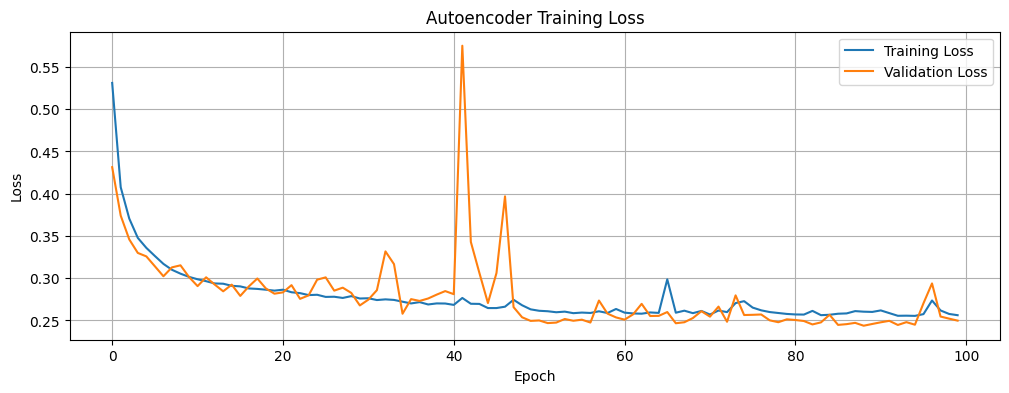

In [ ]:
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

# Define model save path in Google Drive
model_save_path = '/content/drive/MyDrive/autoencoder_model'
os.makedirs(model_save_path, exist_ok=True)
model_file = os.path.join(model_save_path, 'autoencoder3.h5')

# Load all preprocessed files from the Google Drive folder
preprocessed_files = glob.glob(preprocessed_folder_path + '*_freq_preprocessed.pkl')
all_data = []

for file_path in preprocessed_files[:66]:  # Limit to 66 files
    df = pd.read_pickle(file_path)
    all_data.append(df.values)

# Combine all windows into a single array
all_windows = np.vstack(all_data)
print(f"Total number of windows from 66 files: {all_windows.shape[0]}")

# Split data into 80% train and 20% test
train_data, test_data = train_test_split(all_windows, test_size=0.2, random_state=42)
print(f"Training data shape: {train_data.shape}, Test data shape: {test_data.shape}")

# Normalize the data (fit scaler on train data only)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)

# Check if model exists and load it, otherwise train a new one
if os.path.exists(model_file):
    autoencoder = load_model(model_file)
    print(f"Loaded existing model from {model_file}")
else:
    # Define the autoencoder model
    input_dim = train_data.shape[1]
    encoding_dim = 32  # Latent space dimension, adjustable

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

    # Train the autoencoder
    history = autoencoder.fit(train_data_normalized, train_data_normalized,
                             epochs=100,
                             batch_size=64,
                             shuffle=True,
                             validation_split=0.1,
                             verbose=1)

    # Save the trained model
    autoencoder.save(model_file)
    print(f"Trained and saved model to {model_file}")

# Evaluate on test data
test_reconstruction = autoencoder.predict(test_data_normalized)
mse = np.mean(np.power(test_data_normalized - test_reconstruction, 2), axis=1)
threshold = np.percentile(mse, 95)  # 95th percentile as anomaly threshold
anomalies = np.where(mse > threshold)[0]

print(f"Reconstruction MSE mean: {np.mean(mse):.6f}, Threshold: {threshold:.6f}")
print(f"Number of potential anomalies in test data: {len(anomalies)} out of {len(test_data)}")

# Optional: Plot training history (only if newly trained)
#if not os.path.exists(model_file):
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Accuracy: 1.00


<Figure size 800x600 with 0 Axes>

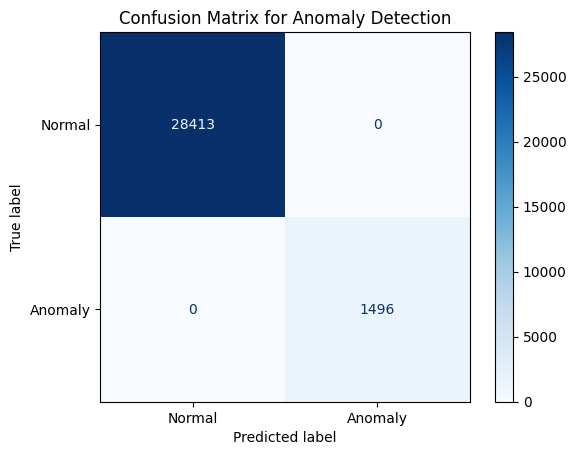

Percentage of anomalies in test data: 5.00%


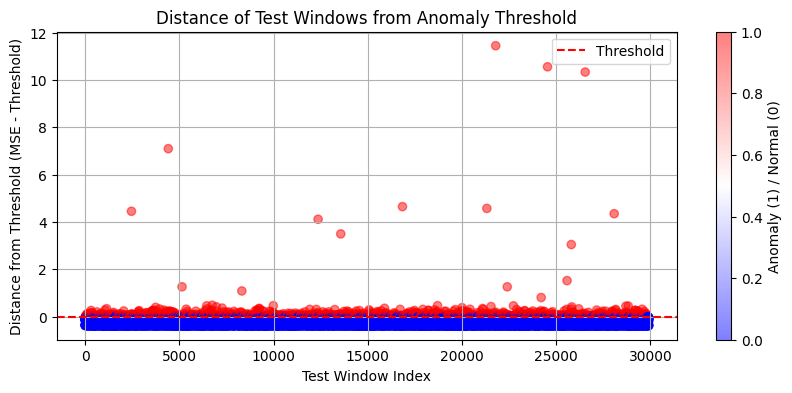

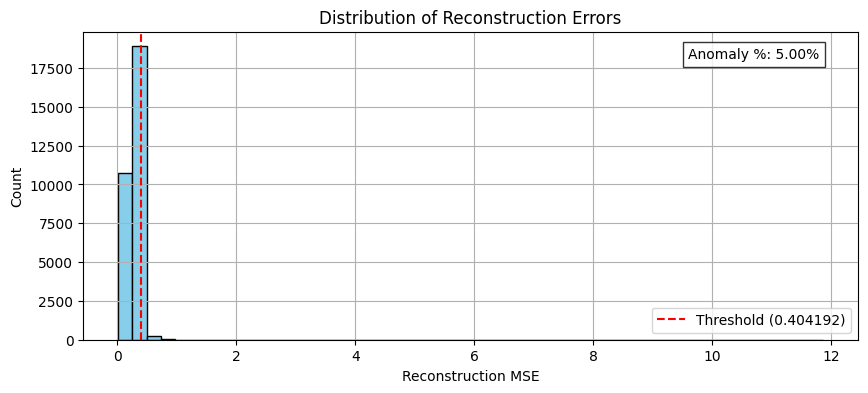

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# Retrieve test data and predictions from Block 6 (assume variables are in memory)
# Note: Rerun Block 6 if these are not available
test_data_normalized = test_data_normalized  # Normalized test data
test_reconstruction = test_reconstruction    # Reconstructed test data
threshold = threshold                        # Anomaly threshold from Block 6

# Compute reconstruction errors
mse = np.mean(np.power(test_data_normalized - test_reconstruction, 2), axis=1)

# Simulate labels based on threshold (1 for anomaly, 0 for normal)
true_labels = (mse > threshold).astype(int)
predicted_labels = (mse > threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='.0f')
plt.title('Confusion Matrix for Anomaly Detection')
plt.show()

# Calculate distance from threshold
distance_from_threshold = mse - threshold

# Calculate percentage of anomalies
anomaly_percentage = (np.sum(predicted_labels) / len(predicted_labels)) * 100
print(f"Percentage of anomalies in test data: {anomaly_percentage:.2f}%")

# Visualize distance from threshold
plt.figure(figsize=(10, 4))
plt.scatter(range(len(distance_from_threshold)), distance_from_threshold, c=predicted_labels, cmap='bwr', alpha=0.5)
plt.axhline(0, color='r', linestyle='--', label='Threshold')
plt.xlabel('Test Window Index')
plt.ylabel('Distance from Threshold (MSE - Threshold)')
plt.title('Distance of Test Windows from Anomaly Threshold')
plt.colorbar(label='Anomaly (1) / Normal (0)')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Plot MSE distribution with threshold and anomaly percentage
plt.figure(figsize=(10, 4))
plt.hist(mse, bins=50, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.6f})')
plt.text(0.95, 0.95, f'Anomaly %: {anomaly_percentage:.2f}%', transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
plt.xlabel('Reconstruction MSE')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.grid(True)
plt.show()

# Backend

In [ ]:
# Install required libraries in Colab
!pip install tensorflow flask pyngrok flask-cors

import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.signal.windows import hamming
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from flask import Flask, request, jsonify, send_file
from flask_cors import CORS
import os
from pyngrok import ngrok

# Verify TensorFlow version
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Set up ngrok with your authtoken
NGROK_AUTH_TOKEN = "2jh7Gm15BiRJdnLPM5ECBNnMzIb_3XiLWry27wFXZtrPf44fi"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Define paths
preprocessed_folder_path = '/content/drive/MyDrive/preprocessed_data/'
model_file = '/content/drive/MyDrive/autoencoder_model/autoencoder.h5'

# Preprocessing function (Block 2)
def preprocess_csv(file_path, window_size=100):
    column_names = ['timestamp', 'x', 'y', 'z']
    df = pd.read_csv(file_path, names=column_names, parse_dates=['timestamp'])

    df = df.sort_values(by='timestamp').reset_index(drop=True)
    df[['x', 'y', 'z']] = df[['x', 'y', 'z']].interpolate(method='linear')
    df = df.dropna()

    scaler_time = StandardScaler()
    df[['x', 'y', 'z']] = scaler_time.fit_transform(df[['x', 'y', 'z']])

    windows = []
    for i in range(0, len(df) - window_size + 1):
        window = df[['x', 'y', 'z']].iloc[i:i + window_size].values
        window_hamming = window * hamming(window_size)[:, np.newaxis]

        fft_x = np.fft.fft(window_hamming[:, 0])
        fft_y = np.fft.fft(window_hamming[:, 1])
        fft_z = np.fft.fft(window_hamming[:, 2])

        mag_x = np.abs(fft_x)
        mag_y = np.abs(fft_y)
        mag_z = np.abs(fft_z)

        n_unique = window_size // 2 + 1
        mag_x = mag_x[:n_unique]
        mag_y = mag_y[:n_unique]
        mag_z = mag_z[:n_unique]

        mag_window = np.concatenate([mag_x, mag_y, mag_z])
        windows.append(mag_window)

    windows_df = pd.DataFrame(windows)
    scaler_freq = StandardScaler()
    windows_scaled = scaler_freq.fit_transform(windows_df)
    return windows_scaled

# Load the model with compile=False
try:
    autoencoder = load_model(model_file, compile=False)
    print(f"Loaded model from {model_file} without compiling")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Flask app setup
app = Flask(__name__)
CORS(app)  # Enable CORS

# Serve the frontend at the root URL
@app.route('/')
def serve_frontend():
    return send_file('/content/index.html')

@app.route('/analyze', methods=['POST'])
def analyze():
    if 'file' not in request.files:
        return jsonify({'error': 'No file uploaded'}), 400

    file = request.files['file']
    if not file.filename.endswith('.csv'):
        return jsonify({'error': 'Please upload a CSV file'}), 400

    file_path = '/content/temp.csv'
    file.save(file_path)

    try:
        windows = preprocess_csv(file_path)
        reconstructions = autoencoder.predict(windows)
        mse = np.mean(np.power(windows - reconstructions, 2), axis=1)

        threshold = 0.833609
        anomalies = mse > threshold
        anomaly_percentage = (np.sum(anomalies) / len(anomalies)) * 100
        distances = mse[anomalies] - threshold
        indices = np.where(anomalies)[0]

        response = {
            'isAnomalous': bool(anomalies.any()),
            'anomalyPercentage': anomaly_percentage,
            'anomalyDistances': distances.tolist(),
            'anomalyIndices': indices.tolist()
        }
        return jsonify(response)
    except Exception as e:
        return jsonify({'error': str(e)}), 500
    finally:
        if os.path.exists(file_path):
            os.remove(file_path)

# Start the Flask server and expose it via ngrok
public_url = ngrok.connect(5000).public_url
print(f"Public URL: {public_url}")

app.run(host='0.0.0.0', port=5000)

  Using cached pyngrok-7.2.5-py3-none-any.whl.metadata (8.9 kB)
  Using cached flask_cors-5.0.1-py3-none-any.whl.metadata (961 bytes)
TensorFlow version: 2.18.0
Loaded model from /content/drive/MyDrive/autoencoder_model/autoencoder.h5 without compiling
Public URL: https://d313-104-199-147-45.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [01/May/2025 07:38:11] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/May/2025 07:38:17] "GET /favicon.ico HTTP/1.1" 404 -
